### Statistical inference


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative
import pandas as pd
from scipy.integrate import quad


In [5]:
plt.style.use('cyberpunk')

In [6]:
cov=pd.read_csv('pantheon+_sys_full_long.txt').to_numpy()
cov


array([[0.03177108],
       [0.00575443],
       [0.00031006],
       ...,
       [0.00588703],
       [0.00875111],
       [0.04499005]])

In [7]:
cov=cov.reshape((1701,1701))

In [8]:
shoes=pd.read_csv('pantheon+_lcparam_full_long_zhel.txt', delimiter=' ')
shoes

,CID,zHD,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,0.00122,0.00082,0.00002,9.74571,1.516210,28.9987,1.516450,29.1770,1,...,0.1071,36,26.88590,0.864470,0.0991,1.4960,0.0381,0.005,1.000,0.003
1,2011fe,0.00122,0.00082,0.00002,9.80286,1.517230,29.0559,1.517470,29.1770,1,...,0.0579,101,88.30640,0.812220,0.0971,1.4960,-0.0252,0.003,1.000,0.004
2,2012cg,0.00256,0.00144,0.00002,11.47030,0.781906,30.7233,0.782372,30.8433,1,...,0.0278,165,233.50000,0.000358,0.0399,0.7134,0.0545,0.019,1.000,0.036
3,2012cg,0.00256,0.00144,0.00002,11.49190,0.798612,30.7449,0.799068,30.8433,1,...,0.0667,55,100.12200,0.000193,0.0931,0.7134,0.0622,0.028,1.000,0.040
4,1994DRichmond,0.00299,0.00187,0.00004,11.52270,0.880798,30.7757,0.881212,-9.0000,0,...,0.0522,146,109.83900,0.988740,0.0567,0.6110,0.0650,0.009,1.000,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,rutledge,1.61505,1.61399,0.00500,25.90650,0.331927,45.1595,0.333024,-9.0000,0,...,1.7256,8,2.92493,0.938980,0.2230,0.0106,-0.0203,0.005,1.000,0.002
1697,geta,1.69706,1.70000,0.04000,26.03330,0.379521,45.2863,0.380480,-9.0000,0,...,1.8973,12,9.15387,0.689730,0.3209,0.0748,0.2680,0.005,0.633,0.000
1698,stone,1.80119,1.80000,0.02000,26.23350,0.280685,45.4865,0.281981,-9.0000,0,...,1.1631,11,11.69320,0.387140,0.2370,0.0358,-0.0968,0.004,0.641,0.000
1699,wilson,1.91165,1.91401,0.00100,26.17030,0.357624,45.4233,0.358642,-9.0000,0,...,1.4902,9,5.54378,0.784570,0.3168,0.0044,-0.3835,0.013,0.604,0.000


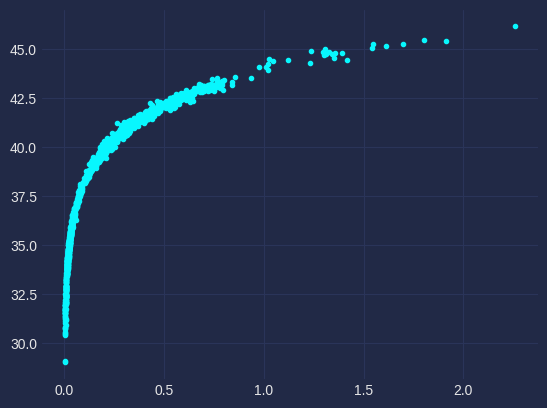

In [9]:
redshift=shoes['zHD'].to_numpy().reshape(-1,1)
mu=shoes['MU_SH0ES'].to_numpy().reshape(-1,1)

plt.plot(redshift, mu,'.')

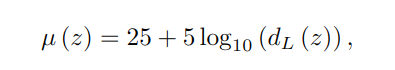

In [10]:
#importing model
nodos=20
ANN =  nn.Sequential(nn.Linear(3, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))

ANN.load_state_dict(torch.load('CPL_param_dict_50'))
ANN.eval()

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=1, bias=True)
)

In [11]:
ANN(torch.tensor([0.1,0.1,0.1]))

tensor([0.9716], grad_fn=<AddBackward0>)

In [12]:
#DL numérica
Omega_m0 = 0.3
Omega_Lambda0 = 0.7
omega_0, omega_a = 1,1

zi=0.0
#zf=3.0

def integrand(z, omega_0, omega_a):
    return 1 / np.sqrt(Omega_m0 * (1 + z)**3 + Omega_Lambda0 * (1 + z)**(3 * (1 + omega_0 + omega_a)) * np.exp(-3 * omega_a * z / (1 + z)))

def DL(omega_0, omega_a):
    dis=np.zeros_like(redshift)
    for i,z0 in enumerate(redshift):
        dis[i],_=quad(integrand, zi, z0,args=(omega_0, omega_a))
    return dis  

Existen basicamente dos maneras de evaluar el likelihood utilizando la red neuronal, el primero es evaluar punto por punto sobre z, para una misma combinación de parámetros libres.

El otro, es completar un arreglo con todos los z y los respectivos parámetros y evlauarlos en una sola propagación hacia delante.

In [14]:
#T = T.to(torch.float)

In [16]:
#T

In [17]:
%%timeit
omega_0, omega_a = 1.0, 1.0

# Se genera un vector con los respectivos parámetros para ser evaluados en la red.
z = torch.tensor(redshift, dtype=float)
T = torch.cat((z, omega_0 * torch.ones_like(z), omega_a * torch.ones_like(z)), 1)
T = T.to(torch.float)

ANN(T)

732 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
%timeit DL(omega_0, omega_a)

157 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit
pred=np.zeros_like(redshift)
omega_0, omega_a = 1.0, 1.0
for i,z0 in enumerate(redshift):
    pred[i] = ANN(torch.tensor([z0.item(),omega_0, omega_a])).detach().numpy()
    

307 ms ± 7.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


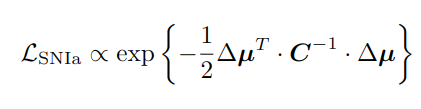

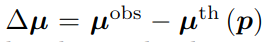

Primero hacemos la inferencia con la función numérica 

$$ d_L = \frac{1+z}{H_0} ANN_{dL}$$

In [20]:
H0=67.0
def ANN_DL(z, omega0,omegaa):
    z = torch.tensor(z, dtype=float)
    T = torch.cat((z, omega0 * torch.ones_like(z),
                    omegaa * torch.ones_like(z)), 1)
    T = T.to(torch.float)
    return (1+z)*ANN(T)/67.0

In [21]:
ANN_DL(redshift,omega0=1,omegaa=1)

tensor([[0.0134],
        [0.0134],
        [0.0134],
        ...,
        [0.0229],
        [0.0234],
        [0.0253]], dtype=torch.float64, grad_fn=<DivBackward0>)

In [22]:
def L(omega0, omegaa):
    MU=5*np.log10(ANN_DL(redshift,omega0,omegaa).detach())+25.0
    d_mu = MU - mu
    exp = np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))
    return exp #np.exp(-exp)

In [23]:
a=5*np.log10(ANN_DL(redshift,omega0=1,omegaa=1).detach())+25.0-mu

In [24]:
np.dot(a.T,np.dot(cov,a))

array([[35716.57032195]])

In [25]:
MU=5*np.log10(ANN_DL(redshift,omega0=0,omegaa=-1).detach())+25.0

In [26]:
#plt.plot(redshift, mu)
#plt.plot(redshift)

In [27]:
redshift.shape

(1701, 1)

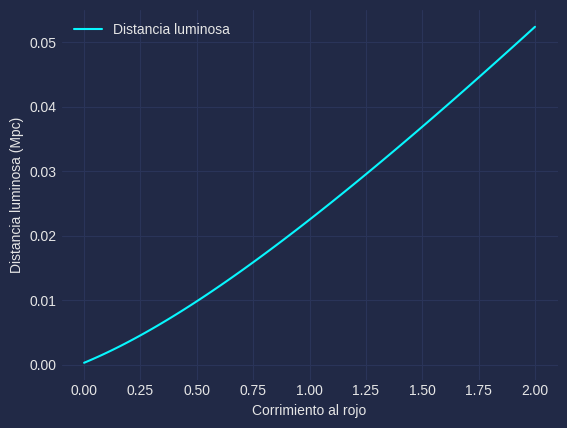

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def distancia_luminosa(z, H0, Om0, OmLambda):
  """
  Calcula la distancia luminosa cosmológica en función del corrimiento al rojo.

  Parámetros:
    z: Corrimiento al rojo cosmológico.
    H0: Constante de Hubble actual.
    Om0: Densidad de materia actual.
    OmLambda: Densidad de energía oscura actual.

  Retorno:
    Distancia luminosa cosmológica en unidades de Mpc.
  """

  # Constante de Hubble en unidades de km/s/Mpc
  H0 = 70

  # Función integrando la ecuación de Friedmann
  def integrand(z):
    return 1 / np.sqrt(Om0 * (1 + z)**3 + OmLambda)

  # Integral numérica
  integral = np.cumsum(integrand(z)) * (z[1] - z[0])

  # Distancia luminosa
  d_lum = (z+1)*integral/H0

  return d_lum

# Parámetros cosmológicos

Om0 = 0.3
OmLambda = 0.7

# Corrimiento al rojo
z = np.linspace(0, 2, 100)

# Distancia luminosa
d_lum = distancia_luminosa(z, H0, Om0, OmLambda)

# Graficar
plt.plot(z, d_lum, label="Distancia luminosa")
#plt.plot(redshift,ANN_DL(redshift, -1,-1).detach())

plt.xlabel("Corrimiento al rojo")
plt.ylabel("Distancia luminosa (Mpc)")
plt.legend()
plt.show()


In [70]:
# Definimos los parámetros cosmológicos
Omega_m0 = 0.3
Omega_Lambda0 = 0.7
omega_0 = -1.0
omega_a = 0.0

# Función a integrar
def integrand(z):
    return 1 / np.sqrt(Omega_m0 * (1 + z)**3 + Omega_Lambda0)
    # return 1 / np.sqrt(Omega_m0 * (1 + z)**3 + 
    #                    Omega_Lambda0 * (1 + z)**(3 * (1 + omega_0 + omega_a)) * np.exp(-3 * omega_a * z / (1 + z)))


def DL(z):
    # Límite inferior de la integral
    z_min = 0.0

    # Límite superior de la integral
    #z_max = 3.0

    # Vector de valores de z
    #z = np.linspace(z_min, z_max, 100)

    # Vector de soluciones de la integral
    resultado = np.zeros_like(z)

    # Calculamos la integral para cada valor de z
    for i in range(len(z)):
        resultado[i], _ = quad(integrand, z_min, z[i])
    return resultado

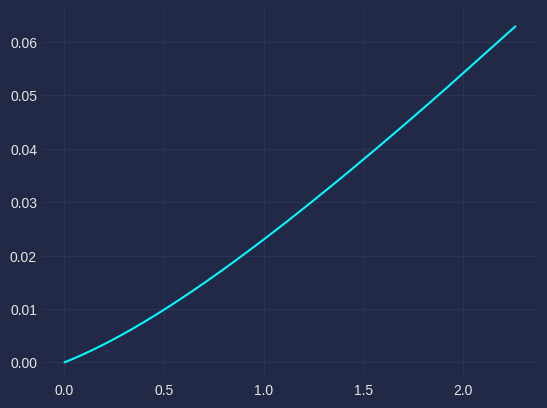

In [75]:
plt.plot(redshift, (1+redshift)*DL(redshift)/67)

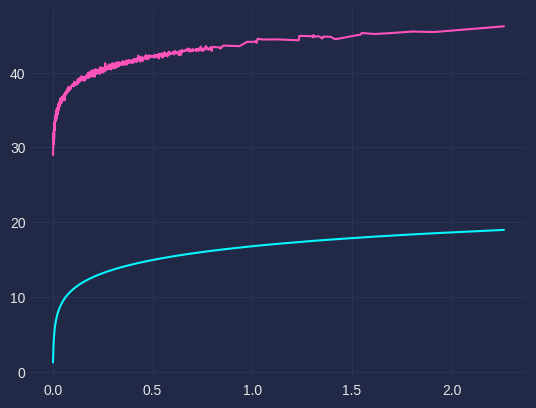

In [74]:
luminosa = (1+redshift)*DL(redshift)/67.0
modulo =25 + 5*np.log10(luminosa)

plt.plot(redshift,modulo)
plt.plot(redshift, mu)

In [50]:
luminosa<0

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])